# Explaining Outcomes from Black Box Models

This notebook demonstrates how SLISE can be used to explain outcomes from black box models.

The way SLISE explains outcomes is based upon locally approximating the complex model with a simpler one.
This is not a new idea, see, e.g., [LIME](https://github.com/marcotcr/lime) and [SHAP](https://github.com/slundberg/shap). What SLISE does different is that we don't create any new (potentially unrealistic) data, and instead use existing data and predictions. The way we accomplish this is by fitting a (sparse) linear model that suits the item being explained, and a subset (/neighbourhood) of items with a bounded error. See the [paper](https://rdcu.be/bVbda) for full details.

## Prerequisites

The example in this notebook assumes that SLISE is installed, which can be done with:
```sh
pip install https://github.com/edahelsinki/pyslise
```
We also need Keras (Tensorflow) for the neural network:

In [1]:
import numpy as np
from tensorflow import keras
import slise
from matplotlib import pyplot as plt

## Dataset

The dataset is the boston housing dataset with 13 variables where the task is to predict the median value of homes in different areas.

In [7]:
(x_train, y_train), (x_test, y_test) = keras.datasets.boston_housing.load_data(seed=42)
variables = ["CRIM", "ZN", "INDUS", "CHAS", "NOX", "RM", "AGE", "DIS", "RAD", "TAX", "PTRATIO", "B", "LSTAT"]

The meaning of the variables are:

| Variable | Description |
|----------|-------------|
| CRIM     | per capita crime rate by town |
| ZN       | proportion of residential land zoned for lots over 25,000 sq.ft. |
| INDUS    | proportion of non-retail business acres per town |
| CHAS     | Charles River dummy variable (= 1 if tract bounds river; 0 otherwise) |
| NOX      | nitric oxides concentration (parts per 10 million) |
| RM       | average number of rooms per dwelling |
| AGE      | proportion of owner-occupied units built prior to 1940 |
| DIS      | weighted distances to five Boston employment centres |
| RAD      | index of accessibility to radial highways |
| TAX      | full-value property-tax rate per $10,000 |
| PTRATIO  | pupil-teacher ratio by town |
| B        | 1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town |
| LSTAT    | % lower status of the population |

The response is the median value of owner-occupied homes in $1000's.

## Model

As the black box model we use a simple neural network with three hidden layers, ReLU activations, batch normalisation, and dropout.

In [8]:
model = keras.Sequential(
    [
        keras.Input(shape=13),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(64, activation="relu"),
        keras.layers.BatchNormalization(),
        keras.layers.Dense(32, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(1),
    ]
)
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 32)                448       
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
dense_5 (Dense)              (None, 64)                2112      
_________________________________________________________________
batch_normalization_3 (Batch (None, 64)                256       
_________________________________________________________________
dense_6 (Dense)              (None, 32)                2080      
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_7 (Dense)              (None, 1)                

In [9]:
model.compile(loss = "mean_squared_error", optimizer="adam")
model.fit(x_train, y_train, batch_size=64, epochs=16, validation_split=0.1)
print("Test loss:", model.evaluate(x_test, y_test))

Epoch 1/16
6/6 [==============================] - 0s 16ms/step - loss: 582.1608 - val_loss: 1049.8585
Epoch 2/16
6/6 [==============================] - 0s 3ms/step - loss: 550.7634 - val_loss: 840.1927
Epoch 3/16
6/6 [==============================] - 0s 2ms/step - loss: 515.0256 - val_loss: 723.1537
Epoch 4/16
6/6 [==============================] - 0s 2ms/step - loss: 485.5012 - val_loss: 657.0096
Epoch 5/16
6/6 [==============================] - 0s 3ms/step - loss: 463.4258 - val_loss: 620.1419
Epoch 6/16
6/6 [==============================] - 0s 2ms/step - loss: 434.9764 - val_loss: 594.6375
Epoch 7/16
6/6 [==============================] - 0s 3ms/step - loss: 414.5994 - val_loss: 579.0774
Epoch 8/16
6/6 [==============================] - 0s 3ms/step - loss: 381.5796 - val_loss: 565.6902
Epoch 9/16
6/6 [==============================] - 0s 3ms/step - loss: 348.7451 - val_loss: 551.4568
Epoch 10/16
6/6 [==============================] - 0s 3ms/step - loss: 319.1407 - val_loss: 532.01

## Explanation

To create the explanation we instruct SLISE to use normalisation, since the variables have widely different magnitudes. This also enables us to use L1 regularisation to create sparser explanations. (The warnings about maximum steps are usually not that serious and can be ignored.)

In [31]:
item = 1
x = x_test[item]
y = model.predict(x_test)[item]
p_train = model.predict(x_train).ravel()
explanation = slise.explain(x_train, p_train, 0.3, x, y, lambda1=0.6, normalise=True)
print("Neighbourhood size:", explanation.subset().mean())

C:\Users\anton\miniconda3\envs\slise\lib\site-packages\slise\optimisation.py:190: SliseWarning: An optimisation step reaches the maximum number of iterations.
  warn(
Neighbourhood size: 0.6188118811881188
C:\Users\anton\miniconda3\envs\slise\lib\site-packages\lbfgs\__init__.py:202: UserWarning: The line-search routine reaches the maximum number of evaluations.
  return opt.minimize(f, x0, progress=progress, args=args)


One of the big advantages of SLISE is that it not only considers the model, but also the dataset. To further this investigation we also plot the distributions of the dataset, and compare the explained item to the rest of the dataset. Furthermore, we have the concept of "impact", which is the (normalised) explained items times the (normalised) approximating model. This allows us to manually reconstruct the prediction by summing together the impacts.

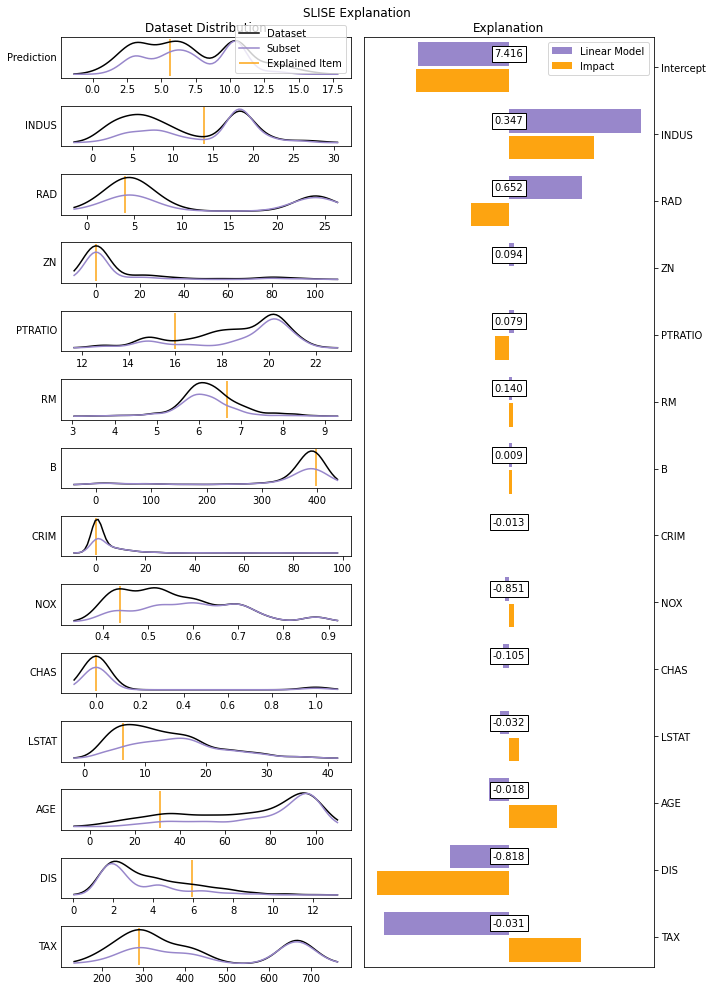

In [32]:
explanation.plot_dist(variables=variables, fig=plt.figure(figsize=(10, 14)))
plt.show()

The location we are investigating is predicted to have a medium home value. The prediction is positively impacted by the availability of jobs (INDUS), how new the houses are (AGE), and the relatively low property tax (TAX, notice the "double negative" that comes from high tax decreasing the value). The main downside is how far the location is from any city centre (DIS).

Notice how the interpretation of the explanation is not only hinged on the local approximation but also how it interacts with the data (primarily the data item we are explaining). The locally approximating linear model tells us how the variables affect the prediction, but we have to combine it with data to understand the given outcome.